# SIIM-ISIC Melanoma Classification

This is my solution to the [SIIM-ISIC Melanoma Classification](https://www.kaggle.com/c/siim-isic-melanoma-classification) competition using ResNet34.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [4]:
path = Path('../input/siim-isic-melanoma-classification')
path_512 = Path('../input/siim-isic-melanoma-classification-jpeg512')

In order to make it easier to train,we will use [resized images](https://www.kaggle.com/itacdonev/siim-isic-melanoma-classification-jpeg512) (Thank you [stats](https://www.kaggle.com/itacdonev)). Working with the current images in the `jpeg/train` folder, it would take 5 hours to run one complete epoch (See Version 1) because the images are of different sizes and fastai would need to resize each batch on the fly. If the images are resized beforehand, it will take less time to train, meaning we can run more epochs.

In [5]:
np.random.seed(2)
data = ImageDataBunch.from_csv(
            path_512, folder='train512', csv_labels='train.csv', ds_tfms=get_transforms(), label_col=7, size=256, suffix='.jpg', num_workers=0
        ).normalize(imagenet_stats)

In [6]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds), data.batch_size

([0, 1], 2, 26501, 6625, 64)

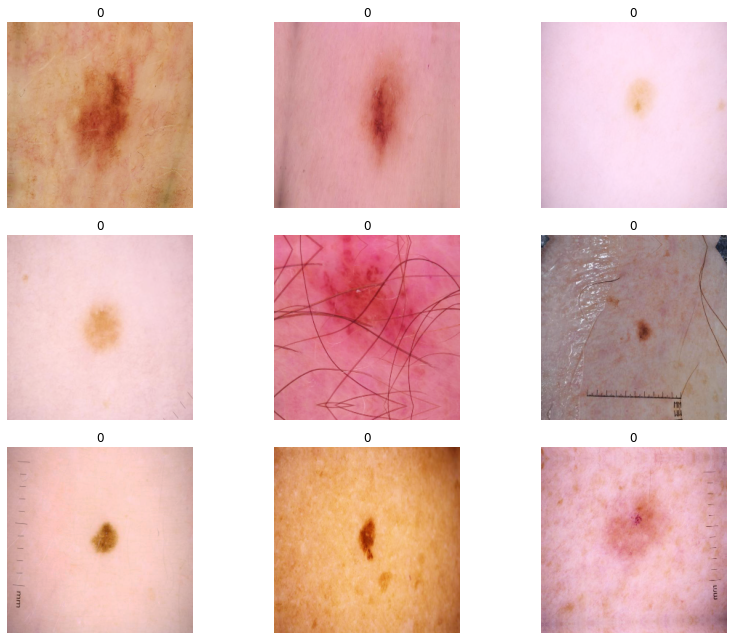

In [7]:
data.show_batch(rows=3, figsize=(12,9))

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=AUROC(), model_dir = '/kaggle/working')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


I set up the `stage-5` model I created in the previous version. I will use this model to attempt to create a better model.

In [9]:
! wget https://www.dropbox.com/s/0tlmorwq1tkhu9b/stage-5.pth

--2020-06-28 13:05:45--  https://www.dropbox.com/s/0tlmorwq1tkhu9b/stage-5.pth
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0tlmorwq1tkhu9b/stage-5.pth [following]
--2020-06-28 13:05:45--  https://www.dropbox.com/s/raw/0tlmorwq1tkhu9b/stage-5.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc11d424deadf1a7d052ba50198c.dl.dropboxusercontent.com/cd/0/inline/A6gz7vkpZAKygtgttWvHtAlGKVr_BWcy0yVSIzCmCzcPkCXtOrxupEKL9mnglP_0qGBeekJoaVRSSSdL8Ryuh4cUBJLAWGAi18B5UpDET3_yelYp1bhGk1JCRyIAOBlcZ_o/file# [following]
--2020-06-28 13:05:45--  https://uc11d424deadf1a7d052ba50198c.dl.dropboxusercontent.com/cd/0/inline/A6gz7vkpZAKygtgttWvHtAlGKVr_BWcy0yVSIzCmCzcPkCXtOrxupEKL9mnglP_0qGBeekJoaVRSSSdL8Ryuh4cUBJLAWGAi18B5UpDET3_yelYp1bhGk

In [10]:
learn.load('stage-5')
learn.data = data

In [11]:
learn.freeze()

epoch,train_loss,valid_loss,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


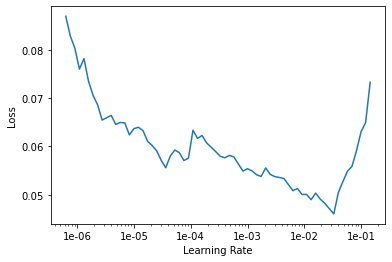

In [12]:
learn.lr_find()
learn.recorder.plot()

We add a callback called `SaveModelCallback` that will save the best model generated by `fit_one_cycle`.

In [14]:
learn.fit_one_cycle(10, max_lr=slice(1e-3, 1e-2), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='auroc', name='stage-6')])

epoch,train_loss,valid_loss,auroc,time
0,0.055730,0.070652,0.887647,13:09
1,0.055121,0.075562,0.883999,11:56
2,0.062309,0.066871,0.899393,12:12
3,0.064822,0.074058,0.883749,11:45
4,0.058748,0.094464,0.884091,11:52
5,0.048008,0.078439,0.889973,11:43
6,0.054113,0.072760,0.880044,11:49
7,0.053153,0.073006,0.881142,11:47
8,0.052043,0.072532,0.885018,12:16
9,0.049806,0.073912,0.884426,12:31


Better model found at epoch 0 with auroc value: 0.8876472115516663.


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Better model found at epoch 2 with auroc value: 0.8993932008743286.


In [17]:
learn.load('stage-6')

Learner(data=ImageDataBunch;

Train: LabelList (26501 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,0,0,0,0
Path: ../input/siim-isic-melanoma-classification-jpeg512;

Valid: LabelList (6625 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,0,0,0,0
Path: ../input/siim-isic-melanoma-classification-jpeg512;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-

In [18]:
learn.export('/kaggle/working/export.pkl')

In [19]:
learner = load_learner('/kaggle/working')

In [20]:
img = open_image(path/'jpeg/test/ISIC_0052060.jpg')


pred_class,pred_idx,outputs = learner.predict(img)

# Get the probability of malignancy

prob_malignant = float(outputs[1]) if str(pred_class) == '0' else float(outputs[0])

print(pred_class)
print(prob_malignant)

0
0.0029901196248829365


In [ ]:
test = os.listdir(path/'jpeg/test')
test.sort(key=lambda f: int(re.sub('\D', '', f)))

with open('/kaggle/working/submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_name', 'target'])
    
    for image_file in test:
        image = os.path.join(path/'jpeg/test', image_file) 
        image_name = Path(image).stem

        img = open_image(image)
        pred_class,pred_idx,outputs = learner.predict(img)
        target = float(outputs[1]) if str(pred_class) == '0' else float(outputs[0])

        
        writer.writerow([image_name, target])